## Estudo de Caso Visual com Grad-CAM em Imagem de raio-x

 Aplicar Grad-CAM em uma rede convolucional treinada para classificar imagens de raio-x como pneumonia ou não pneumonia.

 É utilizado o modelo pré-treinado resnet, ajustado para 2 classes e aplicar Grad-CAM . Usaremos uma imagem de raio-x da base pública Chest X-ray Pneumonia (Kaggle).



In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
import cv2

import requests
from PIL import Image
from io import BytesIO

Carregar a imagem de raio-x

In [ ]:
url = "https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/images/1-s2.0-S0929664620300449-gr2_lrg-b.jpg"
response = requests.get(url)
img = Image.open(BytesIO(response.content)).convert('RGB')

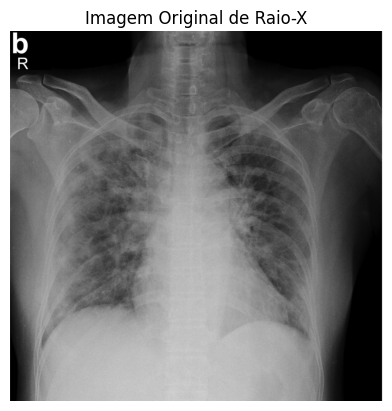

In [ ]:
plt.imshow(img)
plt.title("Imagem Original de Raio-X")
plt.axis('off')
plt.show()

Pré-processamento da Imagem

In [ ]:
img_resized = img.resize((224, 224))
img_array = image.img_to_array(img_resized)
img_batch = np.expand_dims(img_array, axis=0)
img_preprocessed = preprocess_input(img_batch)

Carregar Modelo pré-treinado

In [ ]:
base_model = ResNet50(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)
model = tf.keras.models.Model(inputs=base_model.input, outputs=output)

Predição

In [ ]:
pred = model.predict(img_preprocessed)[0][0]
classe = "Pneumonia" if pred > 0.5 else "Normal"
conf = pred if pred > 0.5 else 1 - pred
print(f"Classe prevista: {classe} (confiança: {conf:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Classe prevista: Pneumonia (confiança: 0.8841)


Grad-CAM

In [ ]:
# Define modelo com saída da última camada convolucional
last_conv_layer = model.get_layer("conv5_block3_out")
grad_model = Model(inputs=model.input, outputs=[last_conv_layer.output, model.output])

In [ ]:
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_preprocessed)
    loss = predictions[:, 0]

In [ ]:
grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

In [ ]:
#Pondera canais pela média dos gradientes
heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

#Normaliza para 0-1
heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
heatmap = heatmap.numpy()

A interpolação bilinear é uma técnica de redimensionamento que calcula o valor de um novo pixel (em uma grade maior ou menor) como uma média ponderada dos 4 pixels vizinhos mais próximos na imagem original.

Com interpolação bilinear:
* A transição de cores e intensidades é suave.
* As bordas das regiões ativadas são mais naturais.
* A sobreposição com a imagem médica final fica mais fiel e interpretável.



In [ ]:
#Redimensiona e aplica colormap
heatmap_resized = cv2.resize(
    heatmap,
    (img.size[0], img.size[1]),
    interpolation=cv2.INTER_LINEAR  # interpolação bilinear
)
heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)

#Sobreposição
original_np = np.array(img)
alpha = 0.5
overlay = cv2.addWeighted(original_np, 1 - alpha, heatmap_colored, alpha, 0)

Gerar Imagens

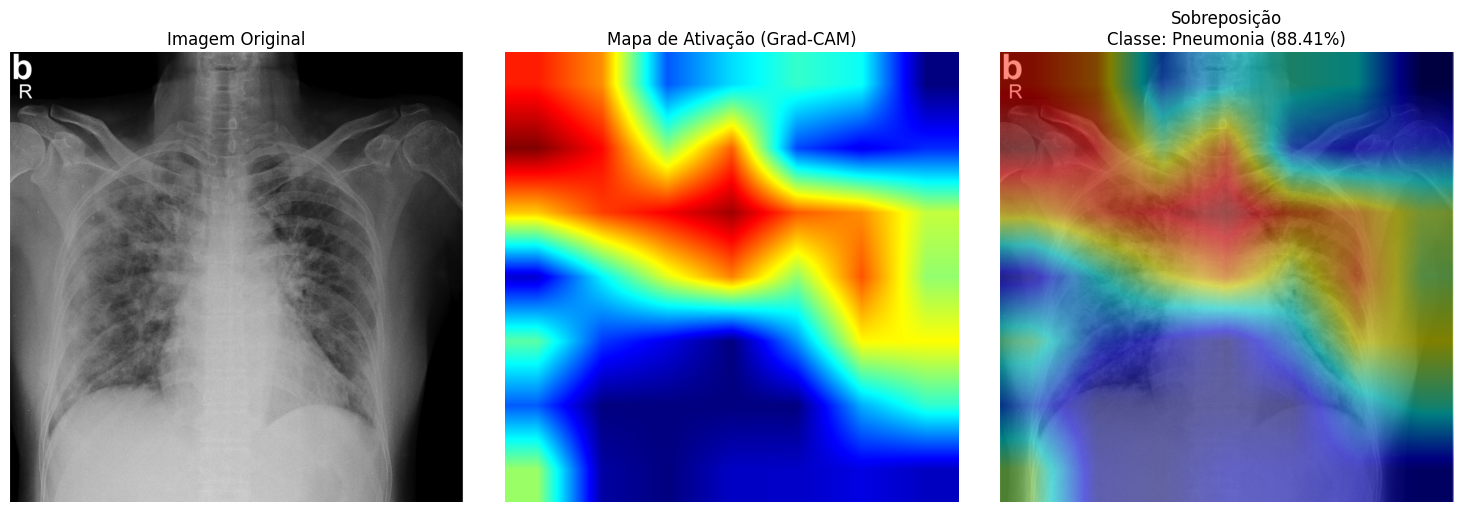

In [ ]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_np)
plt.title("Imagem Original")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(heatmap_colored)
plt.title("Mapa de Ativação (Grad-CAM)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Sobreposição\nClasse: {classe} ({conf:.2%})")
plt.axis('off')

plt.tight_layout()
plt.show()